In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import Var
import numpy as np

In [34]:
# paths to data 
# downloaded from https://eatradingacademy.com/software/forex-historical-data/
paths = ["data/AUDUSD1440.csv",
         "data/GBPUSD1440.csv",
         "data/USDJPY1440.csv",
         "data/EURUSD1440.csv"]

In [35]:
def read_asset_data(path):
    
    ''' function to read a csv file
    with colums:[Time,Open,High,Low,Close,Volume]
    returning a pandas dataframe with index the "Time" and 
    column the "Close" price of the given asset'''
    
    # read csv
    asset = pd.read_csv(path, delimiter='\t', usecols=[0,4],names=['datetime','price'])
    asset.datetime = pd.to_datetime(asset.datetime)
    # set datetime as index
    asset.set_index('datetime', inplace=True)
    asset_name = "".join(re.findall("[a-zA-Z]+", path))[-9:-3]
    asset.rename(columns={"price": asset_name}, inplace=True)
    
    return asset[[asset_name]]

In [37]:
prices.datetime

,AUDUSD,GBPUSD,USDJPY,EURUSD
datetime,,,,
2007-01-01,0.79000,1.96332,118.891,1.32120
2007-01-02,0.79548,1.97295,118.832,1.32724
2007-01-03,0.79140,1.95169,119.330,1.31690
2007-01-04,0.78270,1.94258,118.805,1.30860
2007-01-05,0.77815,1.92900,118.600,1.29995
...,...,...,...,...
2020-12-14,0.75346,1.33249,104.008,1.21486
2020-12-15,0.75572,1.34465,103.647,1.21543
2020-12-16,0.75692,1.35019,103.475,1.21961


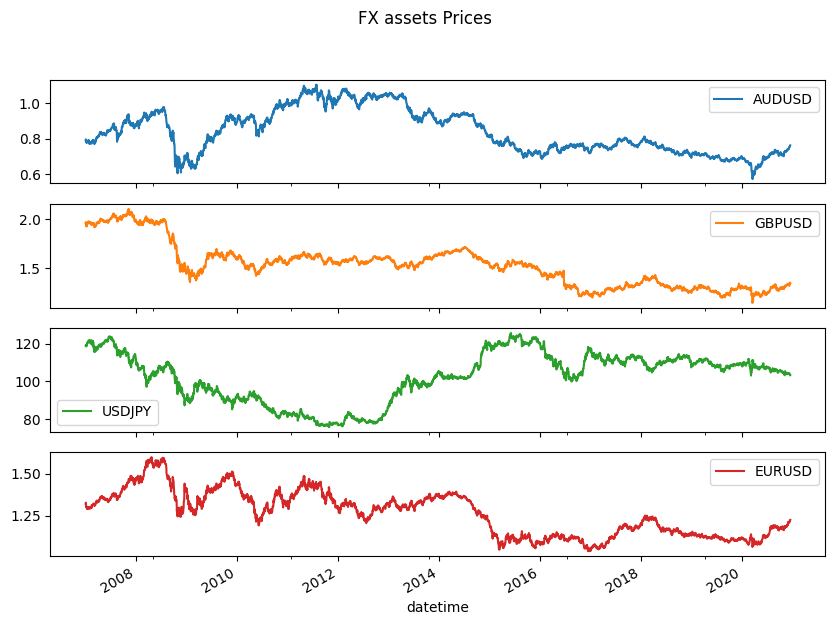

In [36]:
h = {}
# read all data
for i in range(len(paths)):
    h["asset" + str(i)] = read_asset_data(paths[i])
    
# Concat FX prices to one dataframe
prices = pd.concat(h, axis=1)
prices.columns = prices.columns.droplevel()
#prices.fillna(method='pad', axis=0, limit=2,inplace=True)
prices = prices.dropna()
#plot
prices.plot(subplots=True, title='FX assets Prices',figsize=(10, 7))
plt.show()

In [7]:
# asset returns calculation
returns = prices.pct_change().dropna()
# deepar model requires datetime index with constant frequency as input
returns = returns.asfreq(freq='1D', fill_value=0.0)
# we use the last 6 years of the data
returns = returns[returns.index>='2015-01-01']

In [8]:
def merge_dicts(dict1, dict2):
    merged = dict1.copy()
    for key, value in dict2.items():
        if isinstance(value, dict) and key in merged and isinstance(merged[key], dict):
            merged[key] = merge_dicts(merged[key], value)  # Recursively merge nested dictionaries
        else:
            merged[key] = value
    return merged

In [9]:
nombre_portafolio = "Divisas"

In [22]:
w = np.ones([4,1]) * 0.25 
var95 = Var.VaRCalculation(time=1, alpha=95, name=nombre_portafolio).predict(returns, w)
var99 = Var.VaRCalculation(time=1, alpha=99, name=nombre_portafolio).predict(returns, w)

var = merge_dicts(var95, var99)
#combine_into(var99, var95)
var



{'Divisas': {'vc_95': -0.004748584144699023,
  'hs_95': -0.004568142114654137,
  'mc_95': -0.004670868501922106,
  'es_95': -0.0059673076918153765,
  'vc_99': -0.006716013175104564,
  'hs_99': -0.008065142121959315,
  'mc_99': -0.006834271797580437,
  'es_99': -0.007706685805217634},
 'Divisas/AUDUSD': {'vc_95': -0.008759197736171993,
  'hs_95': -0.008610881601188234,
  'mc_95': -0.00861034856138651,
  'es_95': -0.011001757842967209,
  'vc_99': -0.012388300513774675,
  'hs_99': -0.01575665783138422,
  'mc_99': -0.01260095636846363,
  'es_99': -0.014210206865361629},
 'Divisas/GBPUSD': {'vc_95': -0.008471061314016258,
  'hs_95': -0.007843235423953527,
  'mc_95': -0.008362026001947536,
  'es_95': -0.010674769161919955,
  'vc_99': -0.01198078367328957,
  'hs_99': -0.013743460093143086,
  'mc_99': -0.01222136157492386,
  'es_99': -0.013777675296731863},
 'Divisas/USDJPY': {'vc_95': -0.007416021036884834,
  'hs_95': -0.006935873144564963,
  'mc_95': -0.007332923540309812,
  'es_95': -0.0093

In [24]:
import pandas as pd
''' 
mc: Monte Carlo VaR
vc: Variance-covariance VaR
hs: Historical Simulation VaR
es: Expected Shortfall
'''
# Convertir el JSON en un DataFrame
df = pd.DataFrame.from_dict(var, orient='index')
df.reset_index(level=0, inplace=True)
df.rename(columns={'index': 'Activo'}, inplace=True) 

df

,Activo,vc_95,hs_95,mc_95,es_95,vc_99,hs_99,mc_99,es_99
0,Divisas,-0.004749,-0.004568,-0.004671,-0.005967,-0.006716,-0.008065,-0.006834,-0.007707
1,Divisas/AUDUSD,-0.008759,-0.008611,-0.008610,-0.011002,-0.012388,-0.015757,-0.012601,-0.014210
2,Divisas/GBPUSD,-0.008471,-0.007843,-0.008362,-0.010675,-0.011981,-0.013743,-0.012221,-0.013778
3,Divisas/USDJPY,-0.007416,-0.006936,-0.007333,-0.009358,-0.010489,-0.012416,-0.010712,-0.012074
4,Divisas/EURUSD,-0.007145,-0.007045,-0.006994,-0.008945,-0.010106,-0.011892,-0.010249,-0.011562


In [25]:
nombre_activo = "AUDUSD"

In [26]:


fila_deseada = df[df['Activo'] == f"{nombre_portafolio}/{nombre_activo}"]
vc_95 = fila_deseada['vc_95'].values[0]  # Obtiene el valor de "Columna1" en la fila
vc_99 = fila_deseada['vc_99'].values[0]

print(f" vc_95 : {vc_95} ,  vc_99: {vc_99}")

 vc_95 : -0.008759197736171993 ,  vc_99: -0.012388300513774675


In [27]:
data =  returns[nombre_activo]

In [28]:
import pandas as pd
import numpy as np
import plotly.express as px


# Crear un histograma con Plotly
fig = px.histogram(data, nbins=50, title=f" {nombre_portafolio} - {nombre_activo} / Variance-covariance VaR", text_auto=True,  
                   labels={"count": "Frecuencia", "value": "Valor (k)"})


fig.add_vrect(x0=vc_99, x1=vc_95, 
            annotation_text=f"95% : {vc_95:.4f} ", annotation_position="top right",
            fillcolor="red", opacity=0.1, line_width=1,annotation_textangle = 90)

fig.add_vrect(x0=np.min(data), x1=vc_99, 
            annotation_text=f"99% : {vc_99:.4f} ", annotation_position="top right",
            fillcolor="red", opacity=0.3, line_width=1,annotation_textangle = 90)

fig.update_layout(
    xaxis_title_text = f'P&L (S/.)', 
    yaxis_title_text = 'Frecuencia'
    )

fig.update_layout(showlegend=False)

fig

In [29]:
# initialize empty lists to save results
vc95 = []
vc99 = []
hs95 = []
hs99 = []

# iterate over the test set
for i in range(10):

    # calculate DeepVaR for the next day 
    #print("inicio :",-260+i)
    #print("fin :",-10+i)

    # calculate VaR for the next day with both VC and HS methods
    var99 = Var.VaRCalculation(time=1, alpha=99,name=nombre_portafolio).predict(returns.iloc[-260+i:-10+i], w)
    var95 = Var.VaRCalculation(time=1, alpha=95,name=nombre_portafolio).predict(returns.iloc[-260+i:-10+i], w)

    var_i = merge_dicts(var95, var99)

    asset = var_i["Divisas"]

    vc95.append(asset["vc_95"])
    vc99.append(asset["vc_99"])
    hs95.append(asset["hs_95"])
    hs99.append(asset["hs_99"])

In [30]:
pnl = (returns.iloc[-10:] @ w).values.flatten()

In [31]:
pnl

array([ 0.00054453,  0.0029149 , -0.00242379,  0.        ,  0.0028604 ,
        0.0001078 ,  0.00228089,  0.00187189,  0.00325063, -0.00060562])

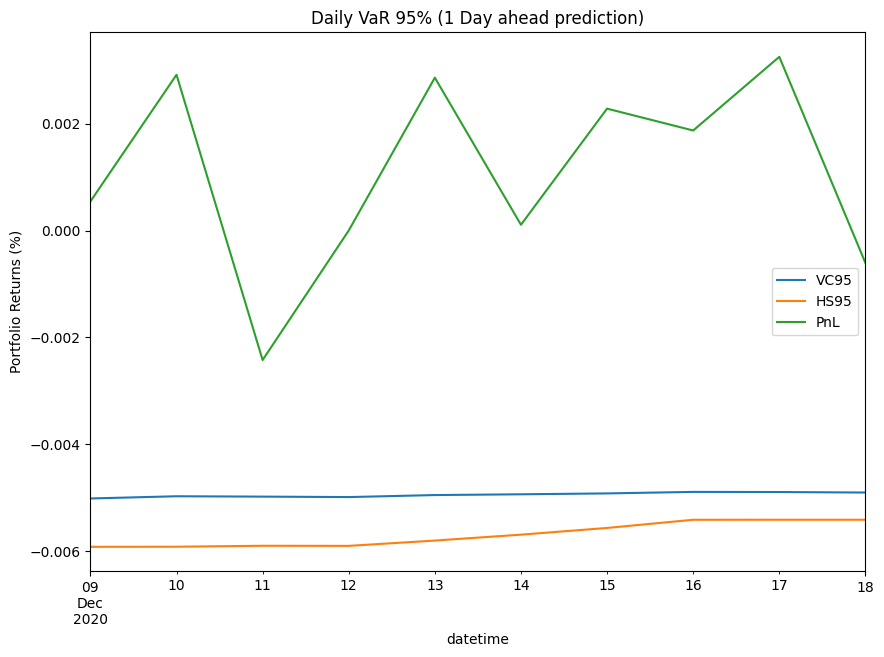

In [32]:
# plot results for 95% VaR
results = pd.DataFrame({'VC95':vc95, 'HS95':hs95, 'PnL':pnl}, index=returns.index[-10:])
results.plot(figsize=(10, 7))
plt.title('Daily VaR 95% (1 Day ahead prediction)')
plt.ylabel('Portfolio Returns (%)')
plt.show()